# Predicting responstimes with a ReLU neural network - improving optimization

In this notebook I want to enhance the optimization procedure. I focus on the case of the crossed diamond, which is the so far most difficult learning task.

I want to have evidence that the excursions of the cost function happen because of occasionally extreme gradients and apply gradient clipping.

I also want to apply a greedy unit-wise supervised pre-training. I want to implement this by manipulating the regularization parameters.

The ultimate goal of the notebook is to improve the minima of the crossed diamond.

In [1]:
from collections import defaultdict
from itertools import count
from pprint import pprint
import theano
import matplotlib.pyplot as plt
import matplotlib.cm as cm
from theano import pp
from theano import tensor as T
from theano import function
from theano.ifelse import ifelse
import numpy as np

/home/dini/anaconda2/lib/python2.7/site-packages/matplotlib/font_manager.py:273: UserWarning: Matplotlib is building the font cache using fc-list. This may take a moment.
  warnings.warn('Matplotlib is building the font cache using fc-list. This may take a moment.')


## Synthetizing data 

In [2]:
class Barrier(object):
    def __init__(self, name):
        self.name = name
        self.in_edges = list()
        self.out_edges = list()

    def __str__(self):
        return "Barrier('{}')".format(self.name)
    __repr__ = __str__
    
    class BarrierDict(defaultdict):
        def __missing__(self, key):
            barrier = self[key] = Barrier(key)
            return barrier
                
class TrxBp(object):
    """ A transaction blue-print
    """
    def __init__(self, name, fr, to, loc=0., scale=1., alpha=-1.0, beta=.10):
        fr.out_edges.append(self)
        to.in_edges.append(self)
        self.fr, self.to = fr, to
        self.name, self.loc, self.scale, self.alpha, self.beta = \
             name,      loc,      scale,      alpha,      beta
        
    def __str__(self):
        if self.loc != 0 or self.scale != 1.:
            return "TrxBp('{}', {:3.1f}, {:3.1f})".format(self.name, self.loc, self.scale)
        else:
            return "TrxBp('{}')".format(self.name)
        
    __repr__ = __str__
        
    def collect_events(self, events, X, refTime=0):
        start  = refTime + np.exp(np.random.normal(self.loc + self.alpha, self.scale * self.beta))
        finish = start   + np.exp(np.random.normal(self.loc             , self.scale            ))
        events.extend([(start, "{" + self.name), (finish, self.name + "}")])
        X.append(finish - start)
        return finish
    
class FSBGraph(object):
    
    def __init__(self):
        self.nodes = Barrier.BarrierDict()
        self.edges = list()
        self.node_count = count(0)
        
    def next_node_id(self):
        return "B{}".format(next(self.node_count))
        
    def add_edge(self, from_id, to_id, loc=0., scale=1., alpha=-1.0, beta=.10):
        name = "{}-->{}".format(from_id, to_id)
        self.edges.append(TrxBp(name, self.nodes[from_id], self.nodes[to_id], 
                                loc, scale, alpha, beta)
                         )
        
    def walk_in_topological_order(self, start_node_id, edge_func, node_func):
        """ Visit each edge and non-start node in a deterministic topological order
        """
        pending_edges = { node: set(node.in_edges) for node in self.nodes.values() }
        pending_nodes = [self.nodes[start_node_id]]
        while pending_nodes:
            from_node = pending_nodes.pop(-1)
            for edge in from_node.out_edges:
                to_node = edge.to
                pending_edges[to_node].discard(edge)
                edge_func(edge)
                if not pending_edges[to_node]:
                    pending_nodes.append(to_node)
                    node_func(to_node)
        if any(pending_edges.values()):
            raise ValueError('Cyclic graph!')

    def collect_events(self, start_node_id, end_node_id, events, X, refTime=0):
        finish_times = dict()
        finish_times[self.nodes[start_node_id]] = refTime
        
        def edge_func(trx):
            #print trx
            finish_times[trx] = trx.collect_events(events, X, finish_times[trx.fr])
    
        def node_func(barrier):
            #print barrier
            finish_times[barrier] = max(finish_times[trx] for trx in barrier.in_edges)
            
        self.walk_in_topological_order(start_node_id, edge_func, node_func)
        return finish_times[self.nodes[end_node_id]] - refTime

In [3]:
g = FSBGraph()
g.add_edge('start', 'end', alpha=-100, beta=0.0)
g.add_edge('start', 'end', alpha=-100, beta=0.0)
X = list()
events = list()
RT = g.collect_events('start', 'end', events, X, refTime=0)
print max(X) - RT

0.0


##### Demonstrate sampling on a crossed diamond structure

Below a 5-edge diamond-like graph is defined:

In [4]:
g = FSBGraph()
g.add_edge('start', 'B1', alpha=-100, beta=0.0)
g.add_edge('start', 'B2', alpha=-100, beta=0.0)
g.add_edge('B1', 'end', alpha=-100, beta=0.0)
g.add_edge('B2', 'end', alpha=-100, beta=0.0)
g.add_edge('B1', 'B2', alpha=-100, beta=0.0)
X = list()
events = list()
rt = g.collect_events('start', 'end', events, X, refTime=0)
print events

[(3.7200759760208361e-44, '{start-->B1'), (1.0543549977187989, 'start-->B1}'), (3.7200759760208361e-44, '{start-->B2'), (0.57090046036706066, 'start-->B2}'), (1.0543549977187989, '{B1-->end'), (3.2606956726273557, 'B1-->end}'), (1.0543549977187989, '{B1-->B2'), (1.5280001418068223, 'B1-->B2}'), (1.5280001418068223, '{B2-->end'), (5.1041144404601617, 'B2-->end}')]


#### Sampling en-mass
The below class can generate training, validation and test data en-mass.

In [5]:
class FSBSampler(object):
    
    def __init__(self, graph, num_children, training_set_size=0, validation_set_size=0, test_set_size=0):
        self.graph = graph
        self.num_children = num_children
        if verbose:
            print ("Generating {} training, {} validation and {} test samples "
                   "using the following concurrency structure:" \
                    .format(training_set_size, validation_set_size, test_set_size))
            print graph
        self.train_X_samples     , self.train_RT_samples      = self.sample(training_set_size  ,) 
        self.validation_X_samples, self.validation_RT_samples = self.sample(validation_set_size,)  
        self.test_X_samples      , self.test_RT_samples       = self.sample(test_set_size      ,)

    def sample(self, N, ):
        """ @param N: number of samples to generate
        """
        X_samples = list()
        RT_samples = list()
        for i in range(N):
            events = list()
            X = list()
            RT = self.graph.collect_events(self.graph.start_node, 
                                           self.graph.end_node, 
                                           events, X)
            X_samples.append(X)
            RT_samples.append(RT)
            
        X_samples = np.array(X_samples)
        RT_samples = np.array(RT_samples)
        return X_samples, RT_samples

In [6]:
class _NonSeq(object):
    def __sub__(self, other):
        if isinstance(other, Sequential):
            other.append(self)
            return other
        else:
            return Sequential((self, other))

class _NonPar(object):
    def __or__(self, other):
        if isinstance(other, Parallel):
            other.append(self)
            return other
        else:
            return Parallel((self, other))

class Sequential(list, _NonPar):
    
    def __str__(self):
        return "(" + " - ".join(str(x) for x in self) + ")"
    __repr__ = __str__
        
    def __sub__(self, other):
        if isinstance(other, Sequential):
            other.extend(self)
            return other
        else:
            self.append(other)
            return self
        
    def generate_graph(self, graph, first=None, last=None):
        if first is None: 
            first = graph.next_node_id()
        fr = first
        for structure in self[:-1]:
            to = graph.next_node_id()
            structure.generate_graph(graph, fr, to)
            fr = to
        if last is None:
            last = graph.next_node_id()
        structure.generate_graph(graph, fr, last)
        return first, last
        
class Parallel(list, _NonSeq):

    def __str__(self):
        return "(" + " | ".join(str(x) for x in self) + ")"
    __repr__ = __str__
    
    def __or__(self, other):
        if isinstance(other, Parallel):
            other.extend(self)
            return other
        else:
            self.append(other)
            return self

    def generate_graph(self, graph, first=None, last=None):
        if first is None: 
            first = graph.next_node_id()
        if last is None:
            last = graph.next_node_id()
        for structure in self:
            structure.generate_graph(graph, first, last)
        return first, last
        
class Trx(_NonSeq, _NonPar):
    
    def __init__(self, name, loc=0., scale=1., alpha=-1.0, beta=.10):
        self.name, self.loc, self.scale, self.alpha, self.beta = \
             name,      loc,      scale,      alpha,      beta
        
    def __str__(self):
        if self.loc != 0 or self.scale != 1.:
            return "Trx('{}', {:3.1f}, {:3.1f})".format(self.name, self.loc, self.scale)
        else:
            return "Trx('{}')".format(self.name)
    __repr__ = __str__

    def generate_graph(self, graph, first=None, last=None):
        if first is None: 
            first = graph.next_node_id()
        if last is None:
            last = graph.next_node_id()
        graph.add_edge(first, last, self.loc, self.scale, self.alpha, self.beta)
        return first, last

##### Verify the correctness of FSB graph construction

Two serial transactions:

In [7]:
g = FSBGraph()
structure = Trx('0', alpha=-100, beta=0) - Trx('1', alpha=-100, beta=0)
start_node, end_node = structure.generate_graph(g)
events = list(); X = list()
RT = g.collect_events(start_node, end_node, events, X, refTime=0)
print sum(X[:2]) == RT

True


Two parallel transactions:

In [8]:
g = FSBGraph()
structure = Trx('0', alpha=-100, beta=0)|Trx('1', alpha=-100, beta=0)
start_node, end_node = structure.generate_graph(g)
events = list(); X = list()
RT = g.collect_events(start_node, end_node, events, X, refTime=0)
print max(X[:2]) == RT

True


The below example produces an FSB graph for two concurrent transactions followed by a third one sequentially.

In [9]:
g = FSBGraph()
structure = Trx('0', alpha=-100, beta=0)|Trx('1', alpha=-100, beta=0) - Trx('2', alpha=-100, beta=0)
start_node, end_node = structure.generate_graph(g)
events = list(); X = list()
RT = g.collect_events(start_node, end_node, events, X, refTime=0)
print max(X[:2] + X[2]) == RT

True


## Learn the crossed-diamond noise-free concurrency structure

In [74]:
def createNWayRNN(n, leak=0, oversizing=1):
    """ @param n: number of inputs to the RNN
        @param leak: slope of the ReLUs for the negative domain 
        @param oversizing: ratio of # of ReLUs to # of inputs
    """
    print "Creating NWayRNN"
    assert n > 0
    m = n * oversizing
    
    class NWayRNN(object):
        
        # every row (selected by 0th coord) is an observation, 
        # fields in a row (1st coord) are child trx resp time in the observation
        X = T.dmatrix('X')  

        # input-to-ReLU connections
        U = theano.shared(np.zeros((n, m)), 'U')
        
        # inter-ReLU connections
        W = theano.shared(np.zeros((m, m)), 'W')
        
        # all the params adjusted during optimisation
        params = [U, W]
        u_shape = (n, m)
        w_shape = (m, m)
        shapes = [u_shape, w_shape]
        
        # every row (selected by 0th coord) is an observation, 
        # fields in a row (1st coord) are input to the n ReLUs
        xU = T.dot(X, U)
        
#         The t=0 instances of the ReLUs
#         h = [T.nnet.relu( xU, alpha=leak )]
# 
#         The t>0 instances of the ReLUs
#         for t in range(1, n):
#             h.append(T.nnet.relu(xU + T.dot(h[-1], W)))

#         h = []
#         for t in range(0, m):
#             # input from the inputs of the RNN
#             input2relu = xU[:,t]  
#             for i in range(t):
#                 # input from the previous ReLUs
#                 input2relu = input2relu + T.dot(h[i], W[i,t] )
#             h.append(T.nnet.relu( input2relu, alpha=leak))

        h = [T.nnet.relu( xU[:,0], alpha=leak )] #
        for t in range(1, m):
            input2relu = xU[:,t] + T.dot(T.stack(h[:t], axis=1), W[:t, t])
            h.append(T.nnet.relu(input2relu, alpha=leak)) 
        
        # The expected response time from the model:
        RT = h[-1]

        # Actual parent resp time, each observation on a separate row
        y = T.dvector('y')

        # residual:
        epsilon = y - RT.T
        
        # Mean squared error
        MSE = 0.5 * T.pow(epsilon, 2).mean() 

        l1 = T.dscalar('lambda1')  # regularization parameter for Lasso
#         l2 = T.dscalar('lambda2')  # regularization parameter for Ridge

        L1 = T.sum(abs(U)) + T.sum(abs(W))
        #L2 = (U**2.0).sum()  + (W**2.0).sum()
#         trilW = T.tril(W)  # lower triangle of W
#         Wdiag = T.nlinalg.diag(W)
#         L2 = T.sum(Wdiag * Wdiag)
#         L2 = T.sum(trilW**2.0)
        
        # the cost function
        E = MSE + l1*L1 #+ l2*L2
        step_size = T.dscalar('step_size')
        momentum = T.dscalar('momentum')

        # the gradients:
        gradEs = [T.grad(E, param) for param in params]
        maxGrad = T.max([T.max(gradE) for gradE in gradEs])

        velocities = [theano.shared(np.zeros(shape)) 
                          for param, shape in zip(params, shapes)]
                
        velocity_updates = [ (velocity, momentum * velocity - step_size * gradE )
                        for velocity, gradE in zip(velocities, gradEs)]
        
        updates = [ (param, param + velocity)
                        for param, velocity in zip(params, velocities)]
        

        training_result_variables = ('RT', 'epsilon', 'MSE', 'E',)
        train = staticmethod(theano.function(
                  inputs = [X, y, step_size, momentum, l1, ], #l2
                  outputs = [RT, epsilon, MSE, E, ] + velocities + [maxGrad],
                  updates = velocity_updates + updates
                    ))
        
        prediction_result_variables = 'RT', 'epsilon', 'MSE'
        predict = staticmethod(theano.function(inputs=[X, y], 
                                               outputs=[RT, epsilon, MSE, xU] + h))

        def __init__(self, step_size, step_size_min, momentum, l_min, l_max, training_steps, data, 
                     batch_size, MSE_limit, rng, num_runs=1):
            assert 0.0 <= momentum < 1.0
            self.step_size, self.momentum, self.training_steps,  self.MSE_limit = \
                 step_size,      momentum,      training_steps,       MSE_limit
            self.l_max, self.l_min, self.step_size_min, = l_max, l_min, step_size_min, 

            if verbose:
                print ("Training the model using the following parameters:"
                       "\nstep_size = {},\tlambda_min = {},\tlambda_max = {},\ttraining_steps = {}" \
                        .format(step_size, l_min, l_max, training_steps))

#             for w, shape in zip(self.params, self.shapes):
#                 w.set_value(rng.uniform(low=-1, high=1, size=shape))  
            lambdas = sorted(np.logspace(l_min, l_max, self.training_steps), 
                             reverse=True)
            step_size_delta = (step_size-step_size_min) / self.training_steps
            
            bestMSE = 1e128
            self.training_results = []
            
            self.maxGrads = list()
            self.MSEs = list()
            self.maxVelos = list()
            for run in range(num_runs):
                if True:
                    self.U.set_value(rng.uniform(low=-1, high=1, size=self.u_shape) * 1e-4)
                    self.W.set_value(rng.uniform(low=-1, high=1, size=self.w_shape)
                                     * (np.ones(self.w_shape) - np.tri(*self.w_shape))
                                    )
                else:
                    self.U.set_value(np.ones(self.u_shape) * 1e-4 )
                    self.W.set_value( (np.ones(self.w_shape) - np.tri(*self.w_shape)) * 1e-0 )

                for i, l_ in zip(range(self.training_steps), lambdas):
                    train_X_samples, train_RT_samples = data.sample(batch_size)
                    result = self.train(train_X_samples, train_RT_samples, self.step_size, 
                                        self.momentum, lambda1=l_, ) #lambda2=l_*100
                    RT, epsilon, MSE, E, velocityU, velocityW, maxGrad = result
#                     print i, MSE
                    self.maxGrads.append(maxGrad)
                    self.MSEs.append(MSE)
                    self.maxVelos.append(max(velocityU.max(), velocityW.max()))
    #                    i < 10 and not i % 3 or \
#                        i < 100 and not i % 30 or \
                    if MSE < bestMSE or \
                       i < 10 and not i % 3 or \
                       i < 100 and not i % 30 or \
                       i < 1000 and i % 300 == 0 or \
                       i< 10000 and i % 3000 == 0 or \
                       i % 10000 == 0:  #MSE < bestMSE or 
                        print 
                        print ("Batch #{}: lambda={:5.3f}, Cost={:5.3f}, "
                               "MSE={:5.3f}, step_size={:5.3f}\nWeights:"
                                .format(i, float(l_), float(E), float(MSE), self.step_size))
#                         for param in self.params:
#                             print param.get_value()
#                         print "Velocities:"
#                         print velocityU
#                         print velocityW
                    else:
                        pass #print '{:5.3f}'.format(float(MSE)),
                    if MSE < bestMSE:
                        bestMSE = MSE
                    if MSE < MSE_limit:
                        break
                    self.step_size -= step_size_delta
                print "Batch #{}: lambda={:5.3f}, Cost={:5.3f}, MSE={:5.3f}\nWeights:"\
                        .format(i, float(l_), float(E), float(MSE))
                for param in self.params:
                    print param.get_value()
#                 print "Velocities:"
#                 print velocityU
#                 print velocityW

                self.training_results.append(
                    dict(zip(self.training_result_variables, result))
                    )
                self.training_results[-1]['training_steps'] = training_steps
                if verbose:
                    print "MSE = {}".format(self.training_results[-1]['MSE'])

        def __call__(self, data):
            prediction_result = self.predict(data.test_X_samples, data.test_RT_samples)
            return dict(zip(self.prediction_result_variables, prediction_result))

        @classmethod
        def evaluate_real(cls, Sampler, num_children, step_size, l_min, l_max, 
                          training_steps, batch_size, N, MSE_limit, rng, parallelSequentialMix=-1, ):
            """ Determine how the real values of the model parameters impact the error.
            """
            results = list() 
            for i in range(N):
                if verbose:
                    print "i = {}".format(i)
                data = Sampler.random_data(num_children=num_children, parallelSequentialMix=parallelSequentialMix, 
                                           training_set_size=5000, validation_set_size=0, test_set_size=5000)
                model = cls(step_size, l_min, l_max, training_steps, data, batch_size, MSE_limit, rng)
                results.append( (data, model.training_results, model(data)))
            return results    ;

    print "Created NWayRNN"
    return NWayRNN

In [75]:
verbose = True
theano.config.optimizer='None'
theano.config.exception_verbosity='high'

In [85]:
%%time
class Diamond(object):
    
    # alpha=-100, beta=0.0 ensure the child response times do not contain
    # additive noise
    graph = FSBGraph()
    graph.add_edge('start', 'B1', alpha=-100, beta=0.0)
    graph.add_edge('start', 'B2', alpha=-100, beta=0.0)
    graph.add_edge('B1', 'end', alpha=-100, beta=0.0)
    graph.add_edge('B2', 'end', alpha=-100, beta=0.0)
    graph.add_edge('B1', 'B2', alpha=-100, beta=0.0)

    #graph.start_node, graph.end_node = graph.nodes['start'], graph.nodes['end']
    graph.start_node, graph.end_node = 'start', 'end'
    data = FSBSampler(graph, num_children=5)
    RNN = createNWayRNN(5, leak=-1.0, oversizing=4)
    rnn = RNN(step_size=2e-7, step_size_min=1e-7, momentum=0.99, l_min=-4, l_max=-2, 
                training_steps=2000, data=data, 
                batch_size=128, MSE_limit=1e-4, rng=np.random.RandomState(1236), num_runs=1)

Generating 0 training, 0 validation and 0 test samples using the following concurrency structure:
Creating NWayRNN
Created NWayRNN
Training the model using the following parameters:
step_size = 2e-07,	lambda_min = -3,	lambda_max = -1,	training_steps = 2000

Batch #0: lambda=0.100, Cost=38.276, MSE=29.233, step_size=0.000
Weights:

Batch #1: lambda=0.100, Cost=30.096, MSE=21.073, step_size=0.000
Weights:

Batch #3: lambda=0.099, Cost=31.835, MSE=22.854, step_size=0.000
Weights:

Batch #6: lambda=0.099, Cost=34.909, MSE=25.990, step_size=0.000
Weights:

Batch #8: lambda=0.098, Cost=24.880, MSE=16.002, step_size=0.000
Weights:

Batch #9: lambda=0.098, Cost=27.690, MSE=18.832, step_size=0.000
Weights:

Batch #12: lambda=0.097, Cost=24.154, MSE=15.356, step_size=0.000
Weights:

Batch #30: lambda=0.093, Cost=31.078, MSE=22.629, step_size=0.000
Weights:

Batch #35: lambda=0.092, Cost=20.431, MSE=12.074, step_size=0.000
Weights:

Batch #46: lambda=0.090, Cost=19.898, MSE=11.739, step_size=0.00

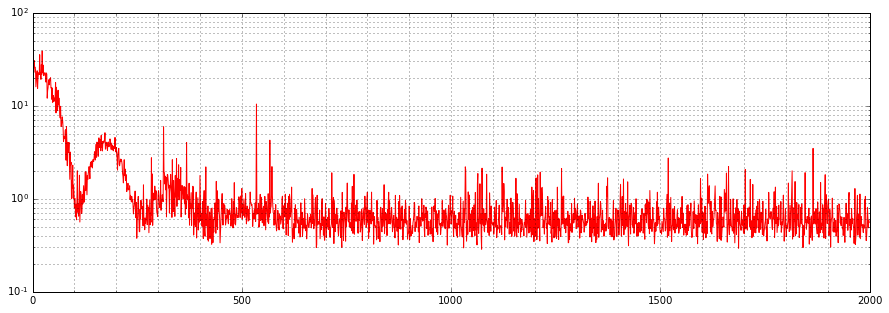

In [105]:
# plt.title('Dependence of the MSE on the actual value of {}'.format(parameter))
plt.figure(figsize=(15, 5))
plt.grid(which='both')
# set_minor_locator(matplotlib.ticker.AutoMinorLocator())
plt.minorticks_on()
plt.plot(Diamond.rnn.MSEs, color='red')
plt.yscale('log')
plt.show()

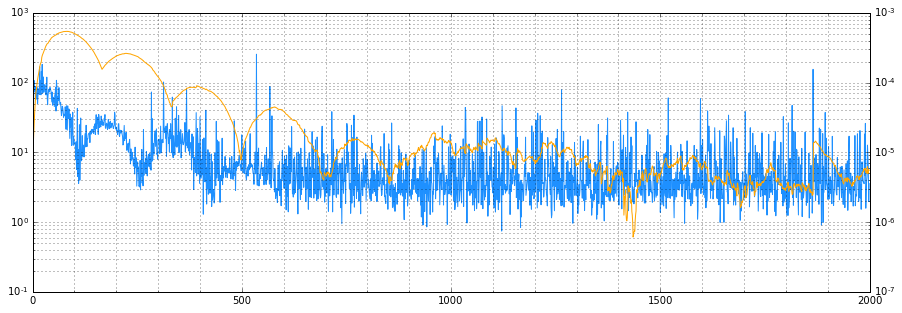

In [110]:
plt.figure(figsize=(15, 5))
plt.grid(which='both')
plt.minorticks_on()
ax1 = plt.gca()
ax2 = ax1.twinx()
ax1.plot(Diamond.rnn.maxGrads, color='dodgerblue')
ax2.plot(Diamond.rnn.maxVelos, color='orange') # 
ax1.set_yscale('log')
ax2.set_yscale('log')
plt.show()

The periods of cc. 100 iterations visible on this plit suggest that the momentum causes the parameter-vector to overshoot and pendle several times around its equilibrium before it settles down. This suggests that the momentum would need to be increased gradually during the training, starting small and reaching its full value after 300 to 500 iterations.

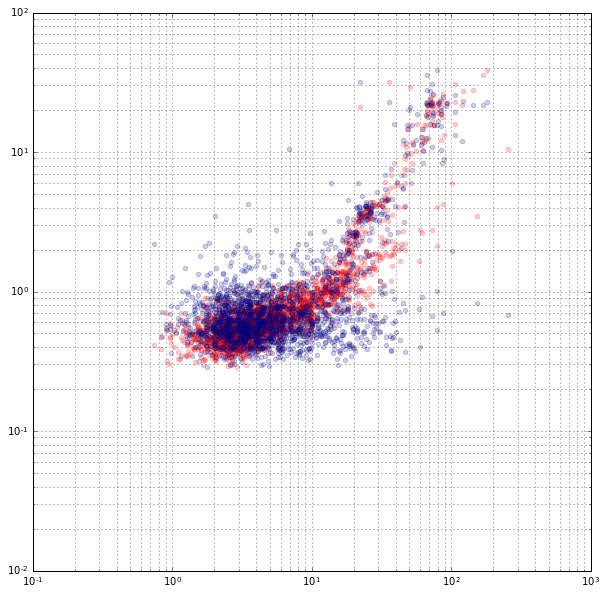

In [112]:
plt.figure(figsize=(10, 10))
plt.grid(which='both')
plt.minorticks_on()
plt.scatter(Diamond.rnn.maxGrads, Diamond.rnn.MSEs, color='red', alpha=0.2)
plt.scatter(Diamond.rnn.maxGrads[:-1], Diamond.rnn.MSEs[1:], alpha=0.2)
plt.xscale('log')
plt.yscale('log')
plt.show()

In these plots I do not see evidence of extreme gradient values diverting the parameter vector. I expected a high gradient is followed in the next iteration step by a high MSE value. The plots show that maxGrad is less correlated to the MSE in the next iteration than to the MSE in the current iteration. This suggests that the high MSE causes high gradients, not the other way around.

The high MSEs are likely to be caused by accidently sampling rare data points that the current parameter values do not explain. To validate this assumption I will plot 2000 minibatches without updating the gradient.

In [ ]:
MSEs = list()
for i in range(2000):
    test_X_samples, test_RT_samples = Diamond.data.sample(128)
    results = Diamond.rnn.predict(test_X_samples, test_RT_samples)
    MSEs.append(results[2])
    

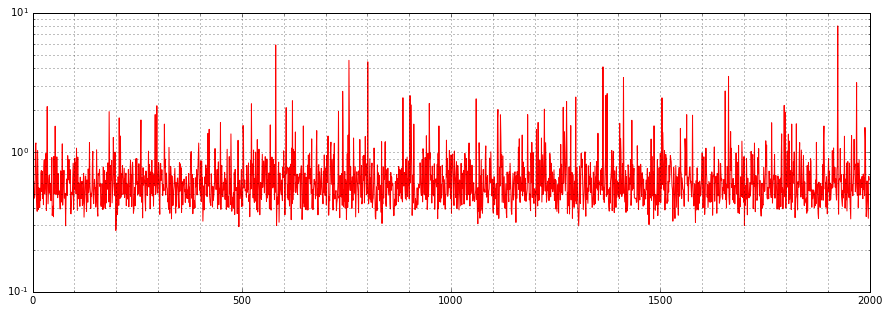

In [114]:
plt.figure(figsize=(15, 5))
plt.grid(which='both')
plt.minorticks_on()
plt.plot(MSEs, color='red')
plt.yscale('log')
plt.show()

The plot is very similar to that of Diamond.rnn.MSEs . Let's examine the distribution of the two data sets after excluding the first 600 data points (which were generated at the beginning of the training when the MSE was still high).

-0.493922900892 -0.514391604363
2.08617809915 1.24866725479


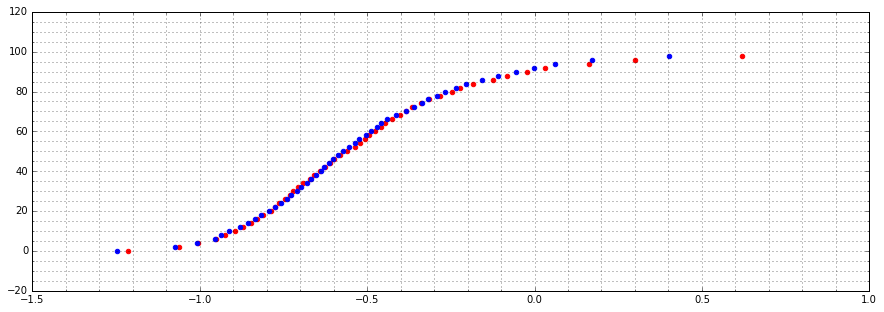

In [126]:
print np.log(MSEs[600:]).mean(), np.log(Diamond.rnn.MSEs[600:]).mean()
print np.log(MSEs[600:]).max(), np.log(Diamond.rnn.MSEs[600:]).max()
    
# for p in range(0, 100, 10):
#     print np.percentile(np.log(MSEs[600:]), p), np.percentile(np.log(Diamond.rnn.MSEs[600:]), p)

plt.figure(figsize=(15, 5))
plt.grid(which='both')
plt.minorticks_on()
for s, c in (MSEs[600:], 'red'), (Diamond.rnn.MSEs[600:], 'blue'):
    l = [(np.percentile(np.log(s), p), p) for p in range(0, 100, 2)]
    plt.scatter(*zip(*l), color=c )
# plt.yscale('log')
plt.show()    

These distributions are very simillar. My conclusion is that the spikes in the training error are caused by the sampling and not because "cliffs" catapult the parameter vector. We would need more of these spikes, so that we can learn from them!

In [46]:
%matplotlib inline